# Credit Card Fraud Detection using Machine Learning
**Author:** Mallikarjun Reddy Banelli
**University:** Clarkson University

This notebook demonstrates a machine learning approach to detecting fraudulent credit card transactions using a Kaggle dataset.

In [10]:
# 1. Import Libraries
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [11]:
# 2. Load Dataset
data = pd.read_csv('creditcard.csv')
data.head(10)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [12]:
# 3. Basic Info
print("Dataset Shape:", data.shape)
print("\nClass Distribution:")
print(data['Class'].value_counts())

Dataset Shape: (284807, 31)

Class Distribution:
Class
0    284315
1       492
Name: count, dtype: int64


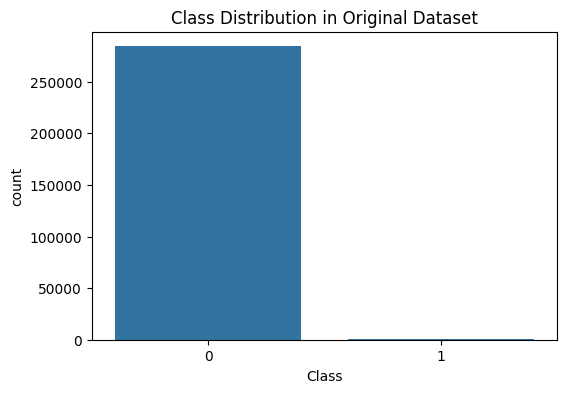

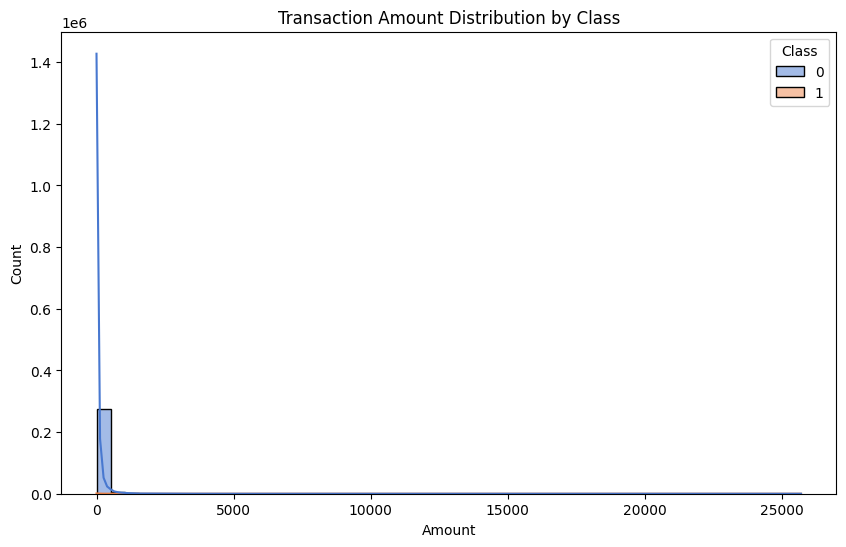

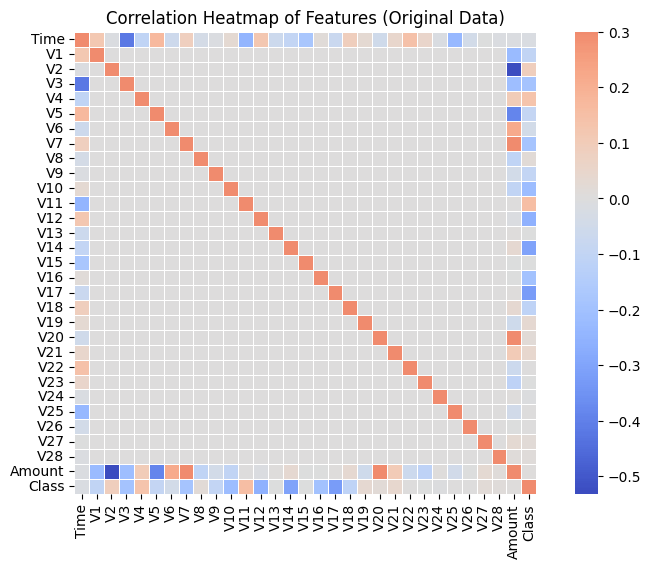

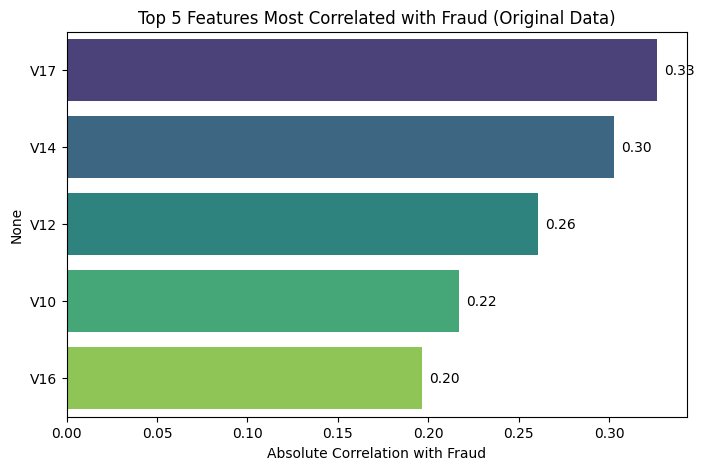

In [13]:
# 4. EDA - Unbalanced Data
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution in Original Dataset')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(data=data, x='Amount', hue='Class', bins=50, kde=True, palette='muted')
plt.title('Transaction Amount Distribution by Class')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(data.corr(), cmap='coolwarm', vmax=0.3, center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Features (Original Data)')
plt.show()

# Top Features Correlated with Fraud
corr_matrix = data.corr()
top_corr_features = corr_matrix['Class'].abs().sort_values(ascending=False)[1:6]
plt.figure(figsize=(8,5))
ax = sns.barplot(x=top_corr_features.values, y=top_corr_features.index, palette='viridis')
plt.title('Top 5 Features Most Correlated with Fraud (Original Data)')
plt.xlabel('Absolute Correlation with Fraud')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=5)
plt.show()

In [14]:
# 5. Features and Target
X = data.drop('Class', axis=1)
y = data['Class']

In [15]:
# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)

Training Set Shape: (227845, 30)
Testing Set Shape: (56962, 30)


In [16]:
# 7. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE - Class Distribution:")
print(pd.Series(y_train_balanced).value_counts())



After SMOTE - Class Distribution:
Class
0    227451
1    227451
Name: count, dtype: int64


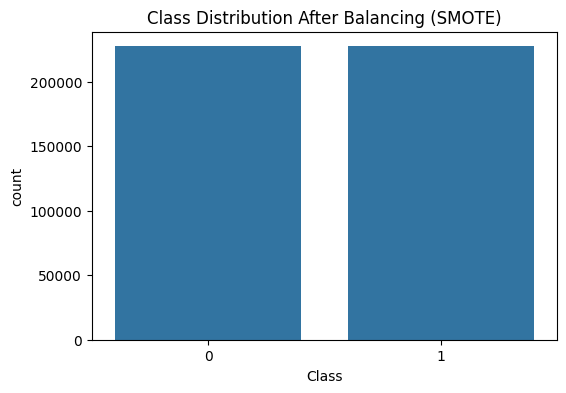

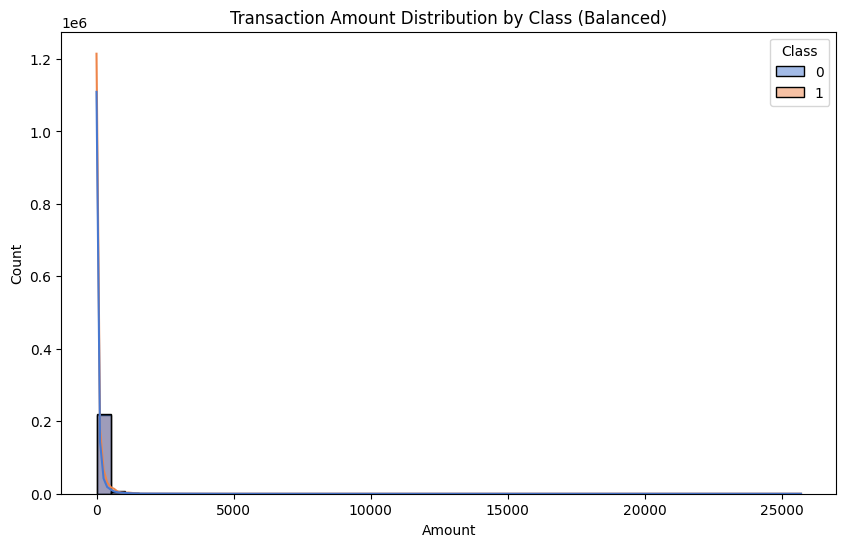

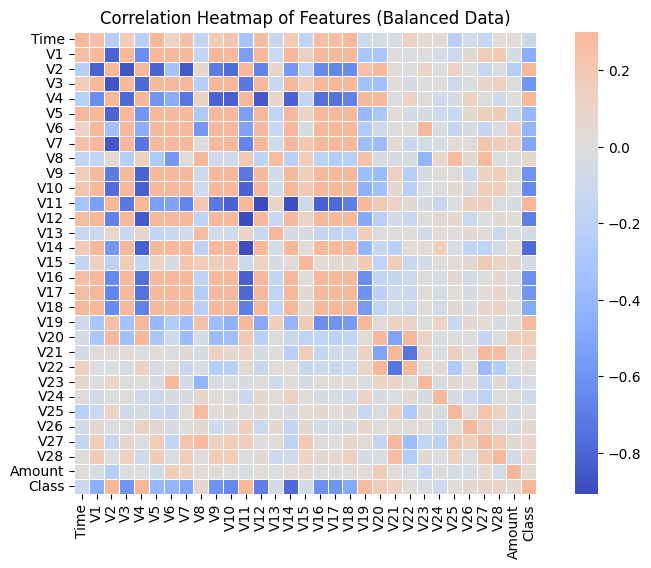

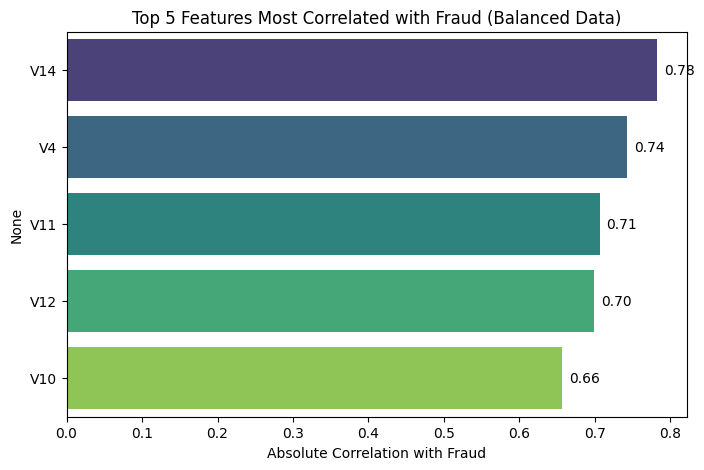

In [18]:
# 9. EDA - Balanced Data
balanced_data = pd.DataFrame(X_train_balanced, columns=data.drop('Class', axis=1).columns)
balanced_data['Class'] = y_train_balanced

plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=balanced_data)
plt.title('Class Distribution After Balancing (SMOTE)')
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(data=balanced_data, x='Amount', hue='Class', bins=50, kde=True, palette='muted')
plt.title('Transaction Amount Distribution by Class (Balanced)')
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(balanced_data.corr(), cmap='coolwarm', vmax=0.3, center=0, square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Features (Balanced Data)')
plt.show()

# Top Features Correlated with Fraud in Balanced Data
corr_matrix_bal = balanced_data.corr()
top_corr_features_bal = corr_matrix_bal['Class'].abs().sort_values(ascending=False)[1:6]
plt.figure(figsize=(8,5))
ax = sns.barplot(x=top_corr_features_bal.values, y=top_corr_features_bal.index, palette='viridis')
plt.title('Top 5 Features Most Correlated with Fraud (Balanced Data)')
plt.xlabel('Absolute Correlation with Fraud')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=5)
plt.show()

In [19]:
10.# Fast Hyperparameter Tuning with HalvingRandomSearchCV and LinearSVC
from sklearn.model_selection import HalvingRandomSearchCV, train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore")  
# Create a small training subset for faster tuning
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_balanced, y_train_balanced, train_size=0.05, random_state=42, stratify=y_train_balanced
)

# Pipeline ensures data scaling before SVM training
pipeline = make_pipeline(StandardScaler(), LinearSVC(max_iter=5000))

# Parameter search space (minimal but effective)
svc_params = {
    'linearsvc__C': [0.01, 0.1, 1, 10],
    'linearsvc__dual': [False, True]
}

# HalvingRandomSearchCV is faster and smarter for hyperparameter search
svc_search = HalvingRandomSearchCV(
    pipeline,
    svc_params,
    cv=3,
    factor=2,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

# Run the search
svc_search.fit(X_train_small, y_train_small)

# Show the best parameters
print("\nBest LinearSVC Parameters:", svc_search.best_params_)



Best LinearSVC Parameters: {'linearsvc__dual': True, 'linearsvc__C': 10}


In [20]:
# 11. Hyperparameter Tuning - Random Forest 
X_train_rf_small, _, y_train_rf_small, _ = train_test_split(
    X_train_balanced, y_train_balanced, train_size=0.05, random_state=42, stratify=y_train_balanced
)

rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf = RandomForestClassifier(random_state=42)
rf_grid = RandomizedSearchCV(
    rf, rf_params, n_iter=5, cv=3, scoring='f1', n_jobs=-1, random_state=42
)
rf_grid.fit(X_train_rf_small, y_train_rf_small)


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, scoring='f1')

In [21]:
# 12. Train Logistic Regression and Decision Tree
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_balanced, y_train_balanced)

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train_balanced, y_train_balanced)

DecisionTreeClassifier(random_state=42)

In [22]:
# 13. Hyperparameter Tuning - XGBoost
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

# Create small subset for fast XGBoost tuning
X_train_xgb_small, _, y_train_xgb_small, _ = train_test_split(
    X_train_balanced, y_train_balanced, train_size=0.05, random_state=42, stratify=y_train_balanced
)

# Parameter grid for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_random = RandomizedSearchCV(
    xgb, xgb_params, n_iter=5, cv=3, scoring='f1', n_jobs=-1, random_state=42
)
xgb_random.fit(X_train_xgb_small, y_train_xgb_small)

print("✅ Best XGBoost Parameters:", xgb_random.best_params_)


✅ Best XGBoost Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}


In [23]:
# 14. Make Predictions on Unbalanced Test Set
best_svc = svc_search.best_estimator_
best_rf = rf_grid.best_estimator_
best_xgb = xgb_random.best_estimator_

svc_preds = best_svc.predict(X_test)
rf_preds = best_rf.predict(X_test)
log_preds = log_reg.predict(X_test)
dt_preds = dt_clf.predict(X_test)
xgb_preds = best_xgb.predict(X_test)


In [25]:
#15. Balance the Test Set and Predict
from imblearn.over_sampling import SMOTE

X_test_balanced, y_test_balanced = SMOTE(random_state=42).fit_resample(X_test, y_test)

svc_preds_balanced = best_svc.predict(X_test_balanced)
rf_preds_balanced = best_rf.predict(X_test_balanced)
log_preds_balanced = log_reg.predict(X_test_balanced)
dt_preds_balanced = dt_clf.predict(X_test_balanced)
xgb_preds_balanced = best_xgb.predict(X_test_balanced)


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    confusion_matrix, accuracy_score, recall_score, 
    precision_score, f1_score, roc_auc_score
)

def plot_conf_matrix_with_metrics(y_true, y_pred, model_name, save_plot=True, suffix="unbalanced"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'{model_name} Confusion Matrix ({suffix})', fontsize=16)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Fraud', 'Fraud'])
    plt.yticks([0.5, 1.5], ['Non-Fraud', 'Fraud'], rotation=0)

    if save_plot:
        filename = f"{model_name.replace(' ', '_')}_ConfusionMatrix_{suffix}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    plt.show()

    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)

    metrics_df = pd.DataFrame({
        'Metrics': ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'ROC AUC'],
        'Values': [f"{acc*100:.2f}%", f"{rec*100:.2f}%", f"{prec*100:.2f}%", f"{f1*100:.2f}%", f"{roc*100:.2f}%"]
    })
    print(metrics_df.to_string(index=False))


🔍 Evaluation on UNBALANCED Test Set


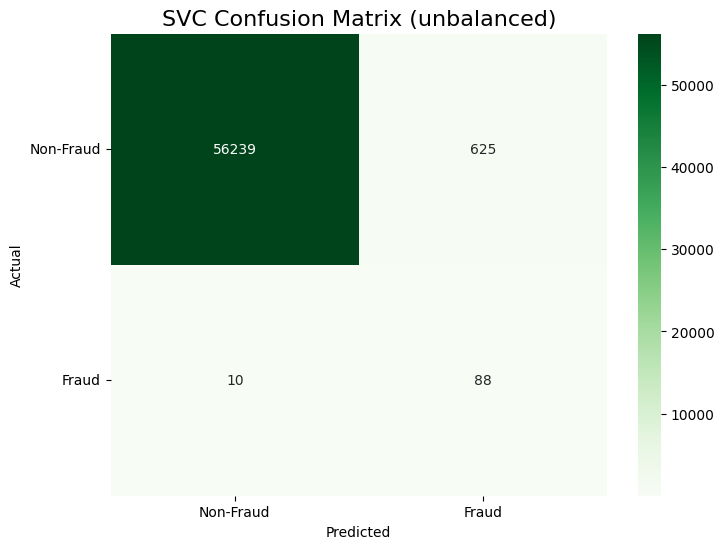

  Metrics Values
 Accuracy 98.89%
   Recall 89.80%
Precision 12.34%
 F1 Score 21.70%
  ROC AUC 94.35%


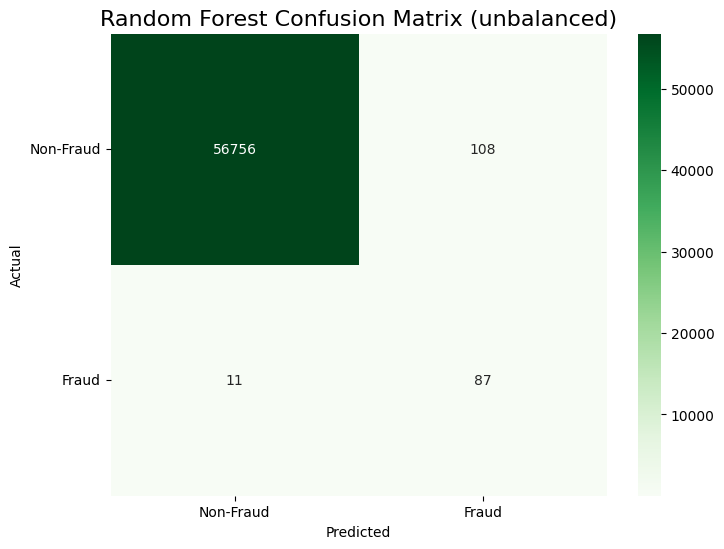

  Metrics Values
 Accuracy 99.79%
   Recall 88.78%
Precision 44.62%
 F1 Score 59.39%
  ROC AUC 94.29%


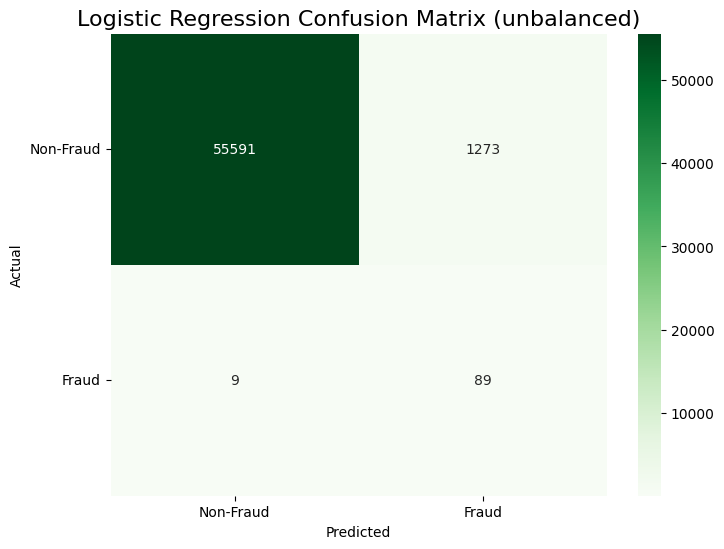

  Metrics Values
 Accuracy 97.75%
   Recall 90.82%
Precision  6.53%
 F1 Score 12.19%
  ROC AUC 94.29%


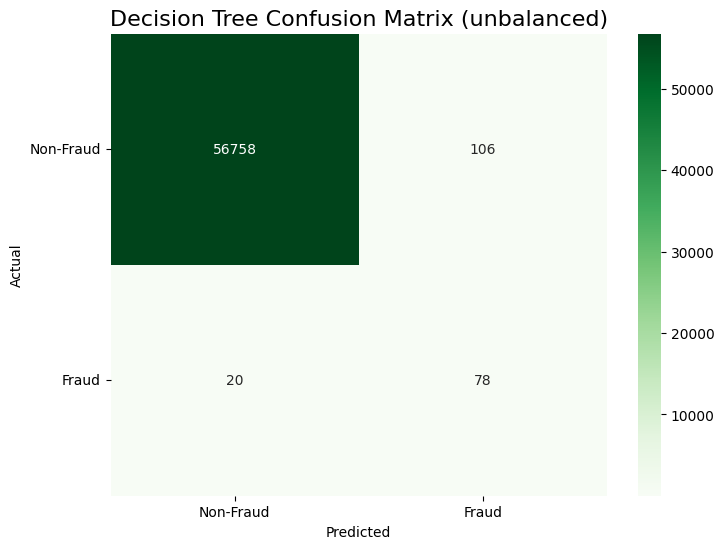

  Metrics Values
 Accuracy 99.78%
   Recall 79.59%
Precision 42.39%
 F1 Score 55.32%
  ROC AUC 89.70%


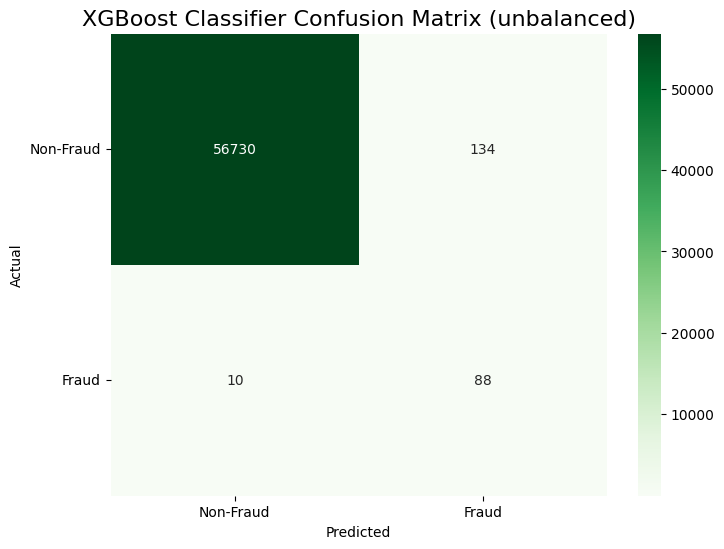

  Metrics Values
 Accuracy 99.75%
   Recall 89.80%
Precision 39.64%
 F1 Score 55.00%
  ROC AUC 94.78%


In [28]:
print("🔍 Evaluation on UNBALANCED Test Set")
plot_conf_matrix_with_metrics(y_test, svc_preds, "SVC", suffix="unbalanced")
plot_conf_matrix_with_metrics(y_test, rf_preds, "Random Forest", suffix="unbalanced")
plot_conf_matrix_with_metrics(y_test, log_preds, "Logistic Regression", suffix="unbalanced")
plot_conf_matrix_with_metrics(y_test, dt_preds, "Decision Tree", suffix="unbalanced")
plot_conf_matrix_with_metrics(y_test, xgb_preds, "XGBoost Classifier", suffix="unbalanced")



🔍 Evaluation on BALANCED Test Set


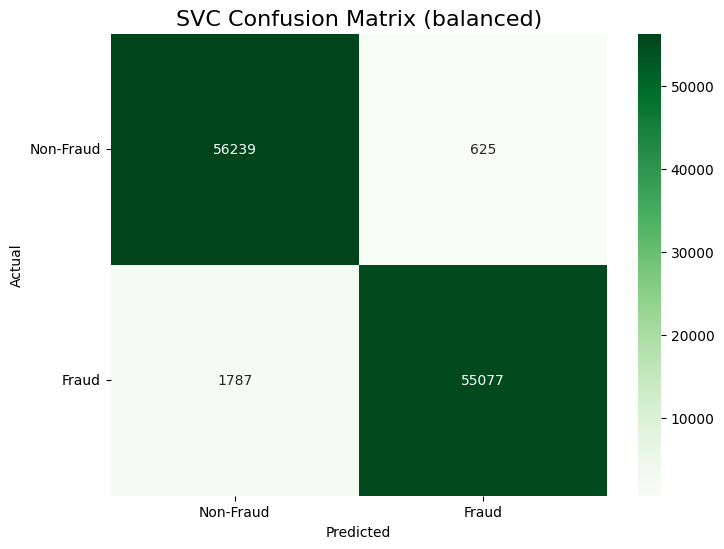

  Metrics Values
 Accuracy 97.88%
   Recall 96.86%
Precision 98.88%
 F1 Score 97.86%
  ROC AUC 97.88%


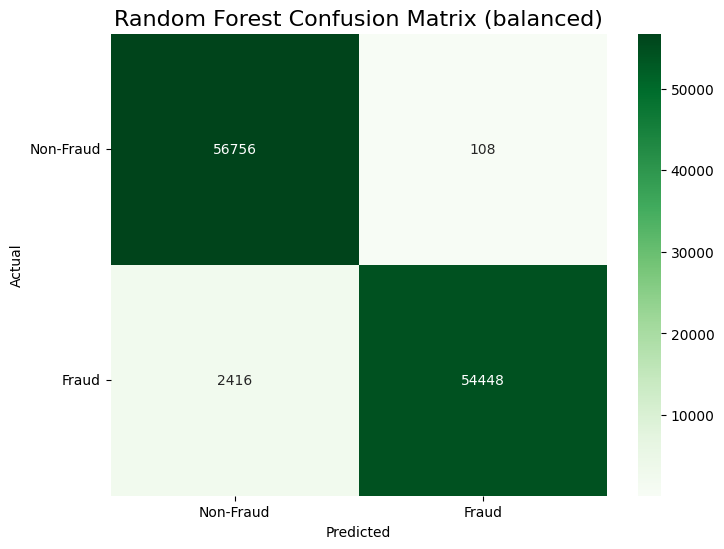

  Metrics Values
 Accuracy 97.78%
   Recall 95.75%
Precision 99.80%
 F1 Score 97.73%
  ROC AUC 97.78%


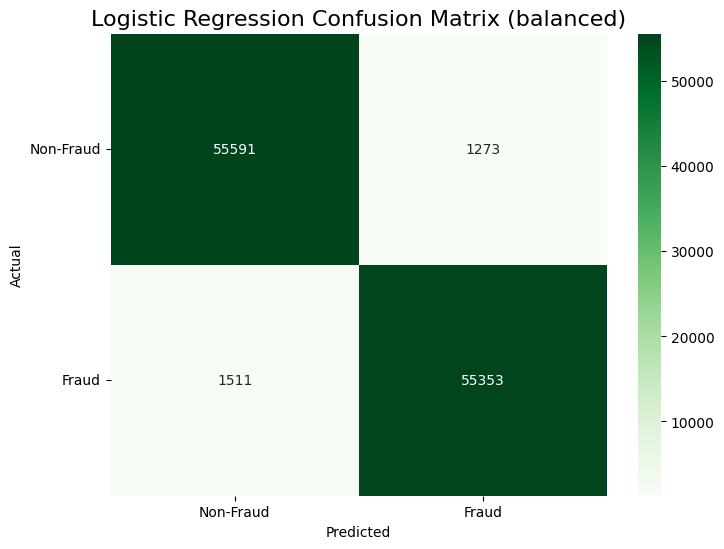

  Metrics Values
 Accuracy 97.55%
   Recall 97.34%
Precision 97.75%
 F1 Score 97.55%
  ROC AUC 97.55%


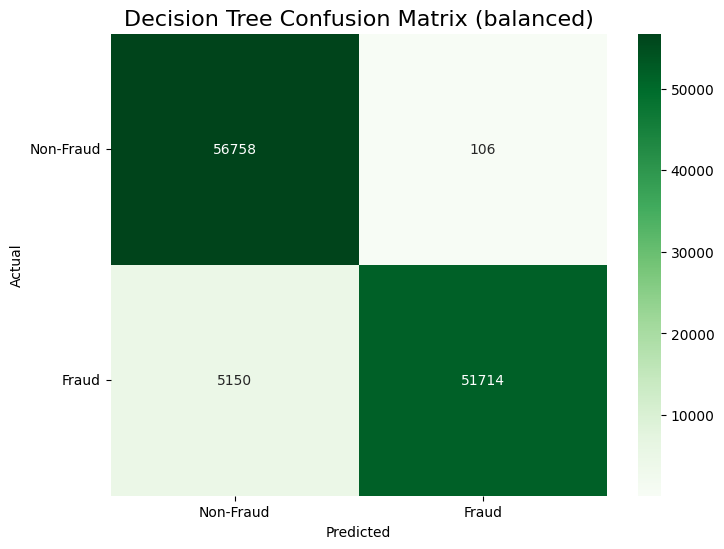

  Metrics Values
 Accuracy 95.38%
   Recall 90.94%
Precision 99.80%
 F1 Score 95.16%
  ROC AUC 95.38%


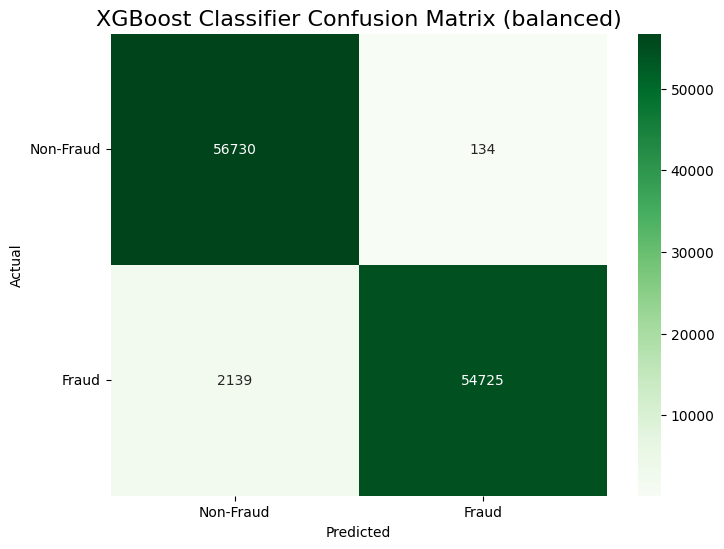

  Metrics Values
 Accuracy 98.00%
   Recall 96.24%
Precision 99.76%
 F1 Score 97.97%
  ROC AUC 98.00%


In [29]:
print("\n🔍 Evaluation on BALANCED Test Set")
plot_conf_matrix_with_metrics(y_test_balanced, svc_preds_balanced, "SVC", suffix="balanced")
plot_conf_matrix_with_metrics(y_test_balanced, rf_preds_balanced, "Random Forest", suffix="balanced")
plot_conf_matrix_with_metrics(y_test_balanced, log_preds_balanced, "Logistic Regression", suffix="balanced")
plot_conf_matrix_with_metrics(y_test_balanced, dt_preds_balanced, "Decision Tree", suffix="balanced")
plot_conf_matrix_with_metrics(y_test_balanced, xgb_preds_balanced, "XGBoost Classifier", suffix="balanced")


In [30]:
# 19. Final Model Performance Comparison (on Unbalanced Test Set)
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

models = {
    "SVC": svc_preds,
    "Random Forest": rf_preds,
    "Logistic Regression": log_preds,
    "Decision Tree": dt_preds,
    "XGBoost": xgb_preds
}

comparison = []
for name, preds in models.items():
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    roc = roc_auc_score(y_test, preds)
    comparison.append([name, acc, rec, prec, f1, roc])

# Create DataFrame
df_comparison = pd.DataFrame(comparison, columns=["Model", "Accuracy", "Recall", "Precision", "F1 Score", "ROC AUC"])
print("\nModel Performance Comparison:")
print(df_comparison.to_string(index=False))

# Optional: Color formatting for notebook view (not required for print)
df_comparison.style.background_gradient(cmap='YlGnBu').format({
    "Accuracy": "{:.2%}",
    "Recall": "{:.2%}",
    "Precision": "{:.2%}",
    "F1 Score": "{:.2%}",
    "ROC AUC": "{:.2%}"
})



Model Performance Comparison:
              Model  Accuracy   Recall  Precision  F1 Score  ROC AUC
                SVC  0.988852 0.897959   0.123422  0.217016 0.943484
      Random Forest  0.997911 0.887755   0.446154  0.593857 0.942928
Logistic Regression  0.977494 0.908163   0.065345  0.121918 0.942888
      Decision Tree  0.997788 0.795918   0.423913  0.553191 0.897027
            XGBoost  0.997472 0.897959   0.396396  0.550000 0.947801


,Model,Accuracy,Recall,Precision,F1 Score,ROC AUC
0,SVC,98.89%,89.80%,12.34%,21.70%,94.35%
1,Random Forest,99.79%,88.78%,44.62%,59.39%,94.29%
2,Logistic Regression,97.75%,90.82%,6.53%,12.19%,94.29%
3,Decision Tree,99.78%,79.59%,42.39%,55.32%,89.70%
4,XGBoost,99.75%,89.80%,39.64%,55.00%,94.78%


<Figure size 1000x600 with 0 Axes>

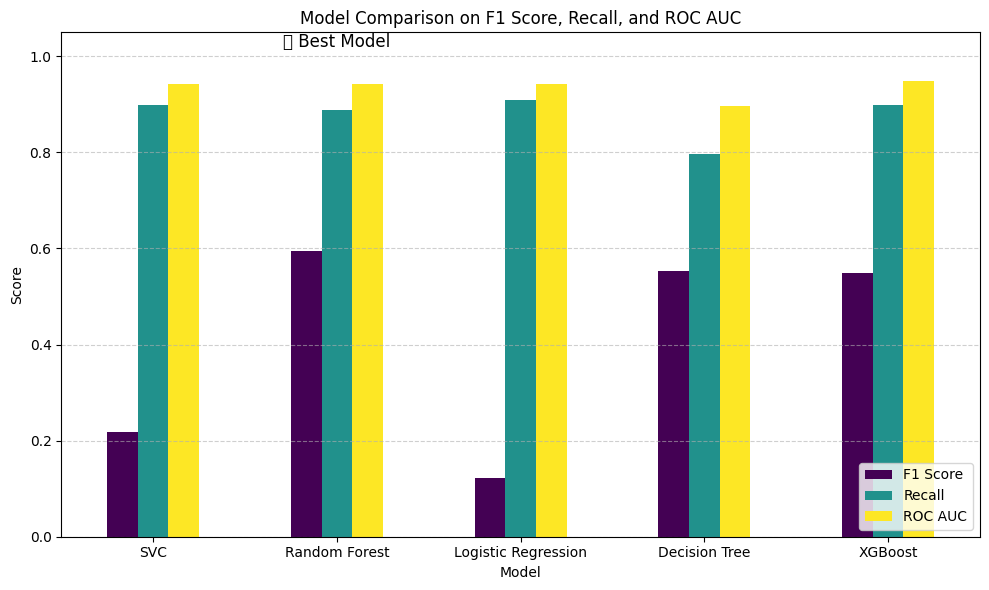


🏆 Best Overall Model: Random Forest — based on highest F1 Score, Recall, and ROC AUC.


In [31]:
# Plot Bar Chart of F1 Score, Recall, and ROC AUC
metrics_to_plot = ["F1 Score", "Recall", "ROC AUC"]
df_plot = df_comparison.set_index("Model")[metrics_to_plot]

plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', figsize=(10,6), colormap='viridis')
plt.title("Model Comparison on F1 Score, Recall, and ROC AUC")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Highlight best model by F1 Score
best_model_idx = df_comparison["F1 Score"].idxmax()
best_model_name = df_comparison.iloc[best_model_idx]["Model"]
plt.text(best_model_idx, 1.02, '🏆 Best Model', ha='center', fontsize=12)

plt.tight_layout()
plt.savefig('model_comparison.png', bbox_inches='tight')
plt.show()

# Print Best Model
print(f"\n🏆 Best Overall Model: {best_model_name} — based on highest F1 Score, Recall, and ROC AUC.")
